In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [32]:
sales = pd.read_csv('train.csv')
sales.tail(10)

,id,date,store_nbr,family,sales,onpromotion
3000878,3000878,2017-08-15,9,MAGAZINES,11.000,0
3000879,3000879,2017-08-15,9,MEATS,449.228,0
3000880,3000880,2017-08-15,9,PERSONAL CARE,522.000,11
3000881,3000881,2017-08-15,9,PET SUPPLIES,6.000,0
3000882,3000882,2017-08-15,9,PLAYERS AND ELECTRONICS,6.000,0
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [33]:
# Check for null values in the dataset.
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [34]:
# Dropping store and item columns.
sales = sales[['date', 'sales']]

In [35]:
# Converting date to datetime.
sales['date'] = pd.to_datetime(sales['date'])
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   sales   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 45.8 MB


In [36]:
# Converting date to Month period ans sum the number of itesm in each month.
sales = sales.set_index('date')
sales = sales.resample('M').sum()

In [37]:
sales.head()

,sales
date,
2013-01-31,1.032762e+07
2013-02-28,9.658960e+06
2013-03-31,1.142850e+07
2013-04-30,1.099346e+07
2013-05-31,1.159770e+07


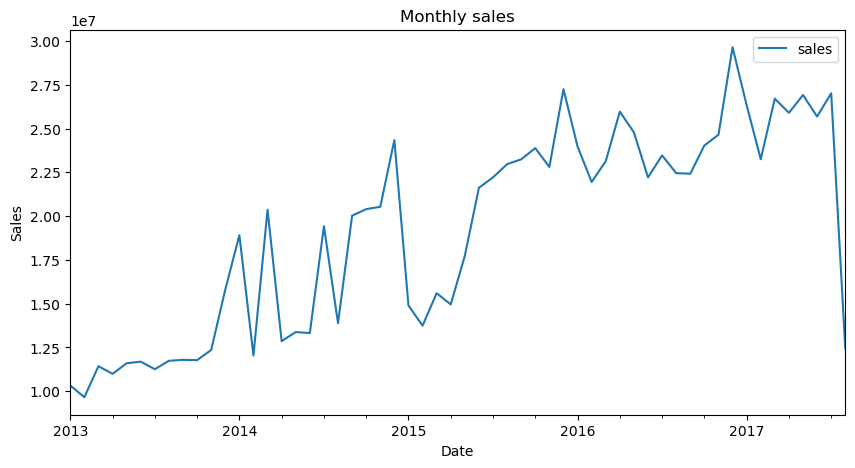

In [38]:
sales.plot(figsize=(10,5))
plt.ylabel('Sales')
plt.xlabel('Date')
plt.title('Monthly sales');

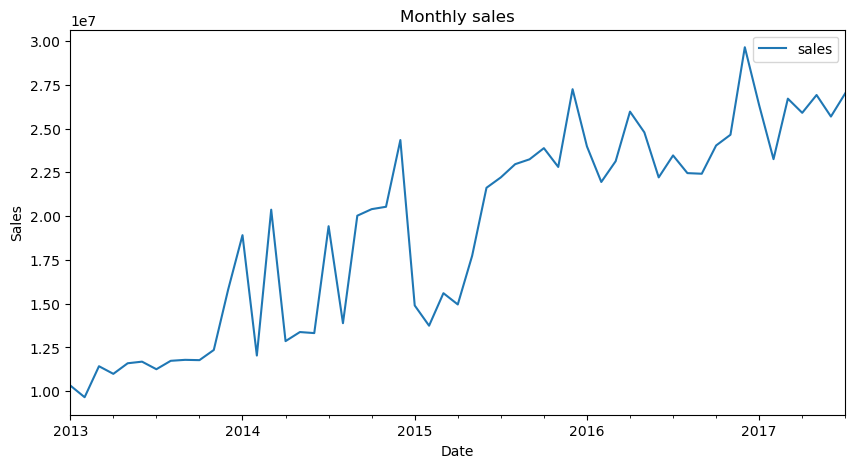

In [39]:
train = sales.drop(sales.tail(1).index)
train.plot(figsize=(10,5))
plt.ylabel('Sales')
plt.xlabel('Date')
plt.title('Monthly sales');

# ARIMA Model

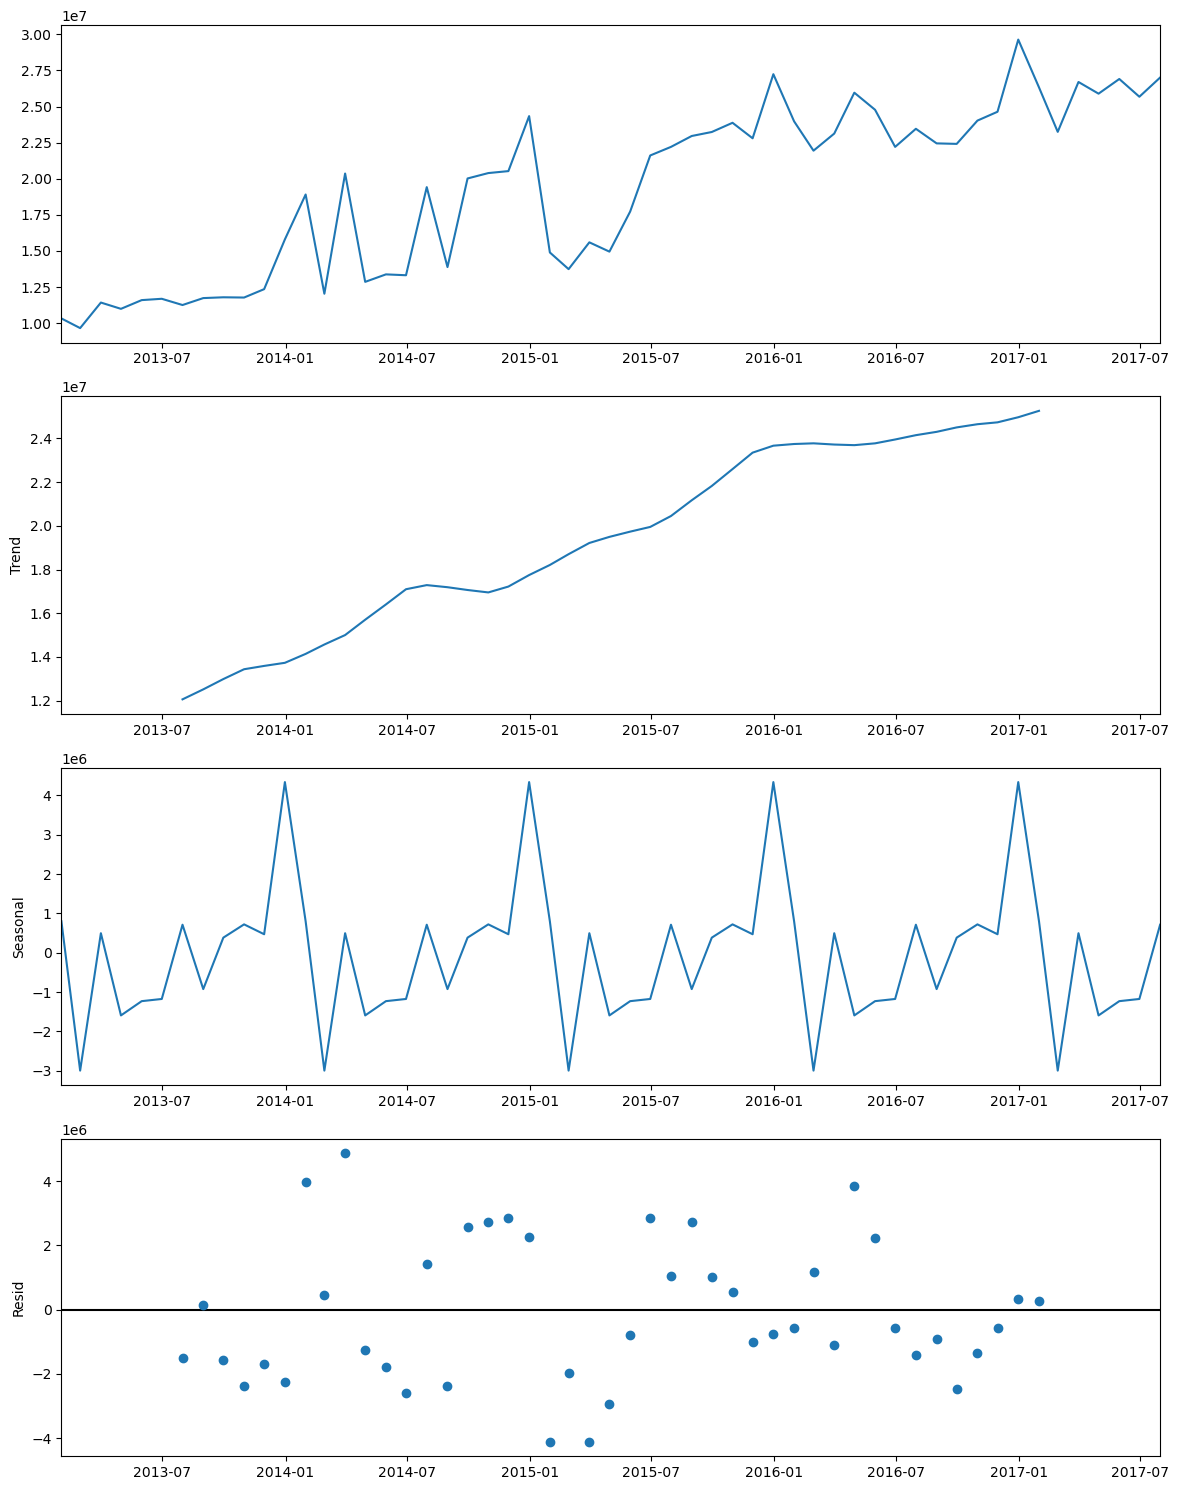

In [40]:
# Seasonal decompose to visualy check seasonality and stationarity
from statsmodels.tsa.seasonal import seasonal_decompose
components = seasonal_decompose(train)

# Plot
fig = components.plot()
fig.set_size_inches((12,15))
fig.tight_layout()
plt.show();

In [41]:
# Augmented Dickie-Fulle test to check for stationarity
from statsmodels.tsa.stattools import adfuller
# HO: unit root is present in the time series; not stationarity
# HA: time series is stationary


In [42]:
# Function to iterate over different timeseries to check stationarity
def test_stationarity(timeseries):

    # Determining rolling statistics
    rol_mean = timeseries.rolling(window=12).mean()
    rol_std = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Actual')
    mean = plt.plot(rol_mean, color='red', label='Rolling mean')
    std = plt.plot(rol_std, color='black', label='Rolling std')
    plt.title('Rolling meand and standard deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', 'Number of observations used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s) '%key] = value
    print(dfoutput)

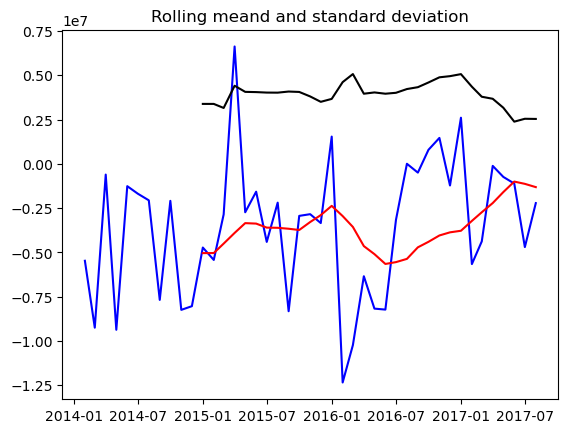

Results of Dickey-Fuller Test:
Test Statistic                 -4.091015
p-value                         0.001002
#Lags used                     10.000000
Number of observations used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


In [43]:
# Data transformation to make it stationary
train_diff = (train.diff() - train.diff(12)).dropna()
test_stationarity(train_diff) # p-value < 0.05

c:\Users\RoccoJustice\anaconda3\envs\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


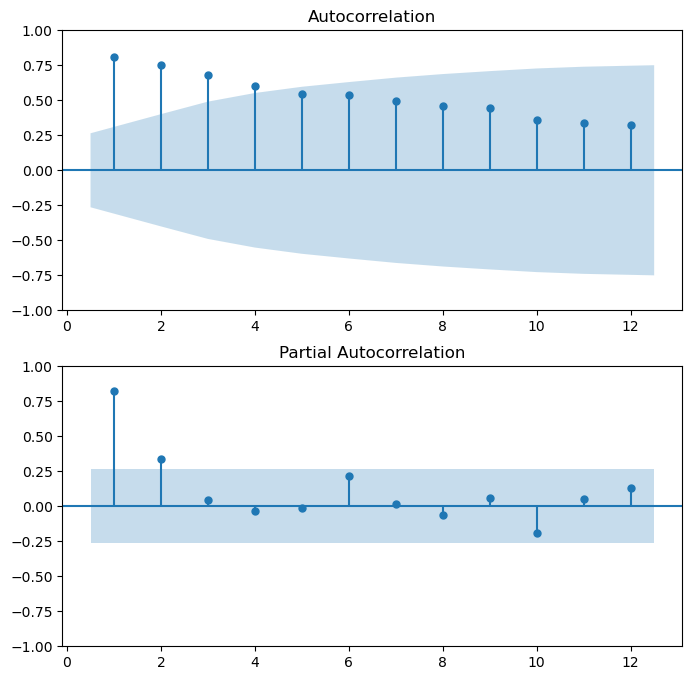

In [44]:
# Determining the order of the model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1 = plot_acf(train, lags=12, zero=False, ax=ax1)
ax2 = plot_pacf(train, lags=12, zero=False, ax=ax2)

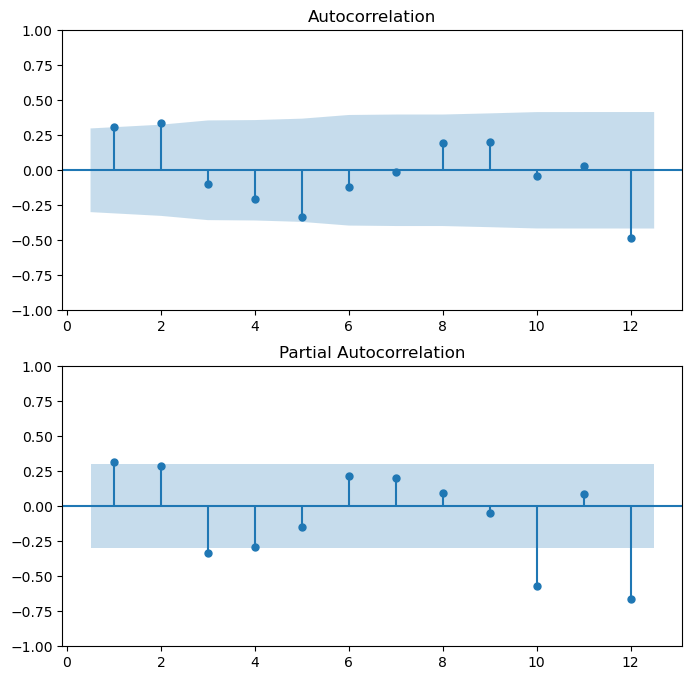

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1 = plot_acf(train.diff(12).dropna(), lags=12, zero=False, ax=ax1)
ax2 = plot_pacf(train.diff(12).dropna(), lags=12, zero=False, ax=ax2)

In [46]:
# ARIMA model gridsearch
import itertools
P=Q=p=q = range(0,4)
D=d = range(0,2)
S = 12
combinations = list(itertools.product(p,d,q,P,D,Q))

arima_orders = list(set([(i[0], i[1], i[2]) for i in combinations]))
seasonal_orders = list(set([(i[3], i[4], i[5], S) for i in combinations]))

grid = pd.DataFrame(columns=['p','d','q','AIC','BIC','MAE'])

In [47]:
grid = pd.DataFrame(columns=['p','d','q','P','D','Q','S','AIC','BIC','Prob(Q)','Prob(JB)','MAE'])

In [48]:
y_train, y_test = train[:'2016-12-31'], train['2017-01-31':]

In [49]:
count = 0
for i in range(len(arima_orders)):
  for j in range(len(seasonal_orders)):
    try:
      model = sm.tsa.statespace.SARIMAX(y_train, order=arima_orders[i], seasonal_order=seasonal_orders[j])
      results = model.fit()
      grid.loc[count, 'p'] = arima_orders[i][0]
      grid.loc[count, 'd'] = arima_orders[i][1]
      grid.loc[count, 'q'] = arima_orders[i][2]
      grid.loc[count, 'P'] = seasonal_orders[j][0]
      grid.loc[count, 'D'] = seasonal_orders[j][1]
      grid.loc[count, 'Q'] = seasonal_orders[j][2]
      grid.loc[count, 'S'] = 12
      grid.loc[count, 'AIC'] = results.aic
      grid.loc[count, 'BIC'] = results.bic
      
      results_summary = results.summary()
      results_as_html = results_summary.tables[2].as_html()
      probq = pd.read_html(results_as_html, header=0, index_col=0)[0].iloc[0,0]
      
      results_summary = results.summary()
      results_as_html = results_summary.tables[2].as_html()
      probjb = pd.read_html(results_as_html, header=0, index_col=0)[0].iloc[0,2]

      mae = np.mean(np.abs(results.resid))

      grid.loc[count, 'Prob(Q)'] = probq
      grid.loc[count, 'Prob(JB)'] = probjb
      grid.loc[count, 'MAE'] = mae
      
      count += 1
      
    except: 
      continue

c:\Users\RoccoJustice\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\RoccoJustice\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\RoccoJustice\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\RoccoJustice\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWar

In [50]:
grid[(grid['Prob(Q)'] > 0.05) & (grid['Prob(JB)'] > 0.05)].sort_values(['AIC', 'BIC',]).head(10)

,p,d,q,P,D,Q,S,AIC,BIC,Prob(Q),Prob(JB),MAE
261,1,1,0,2,1,0,12,1163.327328,1169.54872,0.77,0.2,2457847.351571
101,0,1,3,2,1,0,12,1163.521452,1172.853541,0.78,0.44,2505317.863732
325,1,1,3,2,1,0,12,1163.71167,1174.599107,0.64,0.3,2443467.30018
109,0,1,3,3,1,0,12,1163.778466,1174.665902,0.66,0.46,2537890.919091
141,2,1,3,3,1,0,12,1163.778951,1177.777084,0.44,0.11,2488895.727048
333,1,1,3,3,1,0,12,1164.166231,1176.609015,0.56,0.28,2482515.878763
113,0,1,3,2,1,1,12,1164.467204,1175.354641,0.7,0.49,2541239.656539
337,1,1,3,2,1,1,12,1164.680647,1177.123432,0.58,0.3,2479050.529875
149,2,1,3,0,1,2,12,1164.837713,1177.280497,0.26,0.06,2523297.718605
845,3,1,3,3,1,0,12,1164.848726,1180.402206,0.25,0.14,2461914.136634


In [51]:
grid[(grid['Prob(Q)'] > 0.05) & (grid['Prob(JB)'] > 0.05)].sort_values(['BIC', 'AIC',]).head(10)

,p,d,q,P,D,Q,S,AIC,BIC,Prob(Q),Prob(JB),MAE
261,1,1,0,2,1,0,12,1163.327328,1169.54872,0.77,0.2,2457847.351571
773,0,1,1,2,1,0,12,1165.492966,1171.714359,0.59,0.27,2500085.405427
101,0,1,3,2,1,0,12,1163.521452,1172.853541,0.78,0.44,2505317.863732
269,1,1,0,3,1,0,12,1165.176451,1172.953191,0.75,0.21,2460363.92748
273,1,1,0,2,1,1,12,1165.192146,1172.968886,0.76,0.21,2460574.59852
69,2,1,0,2,1,0,12,1165.217063,1172.993804,0.74,0.19,2450786.586065
997,1,1,1,2,1,0,12,1165.290397,1173.067138,0.72,0.18,2449538.619448
453,0,1,2,2,1,0,12,1165.737118,1173.513859,0.66,0.21,2454826.655962
264,1,1,0,0,1,3,12,1165.817831,1173.594571,0.76,0.07,2446033.665845
325,1,1,3,2,1,0,12,1163.71167,1174.599107,0.64,0.3,2443467.30018


In [62]:
model = sm.tsa.statespace.SARIMAX(y_train, order=(0,1,3), seasonal_order=(2,1,0,12)) # This model matches with what we saw in the acf and pacf plots
results = model.fit()

y_fit = results.get_prediction(start=-24)
y_fit = y_fit.predicted_mean

y_pred = results.get_forecast(steps=7)
y_pred_mean = y_pred.predicted_mean

confidence_intervals = y_pred.conf_int()

c:\Users\RoccoJustice\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [64]:
lower_limits = confidence_intervals['lower sales']
upper_limits = confidence_intervals['upper sales']

In [65]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                   48
Model:             SARIMAX(0, 1, 3)x(2, 1, [], 12)   Log Likelihood                -575.761
Date:                             Fri, 24 Feb 2023   AIC                           1163.521
Time:                                     18:03:50   BIC                           1172.854
Sample:                                 01-31-2013   HQIC                          1166.743
                                      - 12-31-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3878      0.244     -1.587      0.113      -0.867       0.091
ma.L2          0.0475      0.210      0.226      0.821      -0.364       0.459
ma.L3         -0.1639      0.262     -0.627      0.531      -0.677       0.349
ar.S.L12      -0.4909      0.162     -3.026      0.002      -0.809      -0.173
ar.S.L24      -0.6467      0.124     -5.202      0.000      -0.890      -0.403
sigma2      1.018e+13   6.35e-15    1.6e+27      0.000    1.02e+13    1.02e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 1.66
Prob(Q):                              0.78   Prob(JB):                         0.44
Heteroskedasticity (H):               0.43   Skew:                            -0.53
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.75e+42. Standard errors may be unstable.
"""

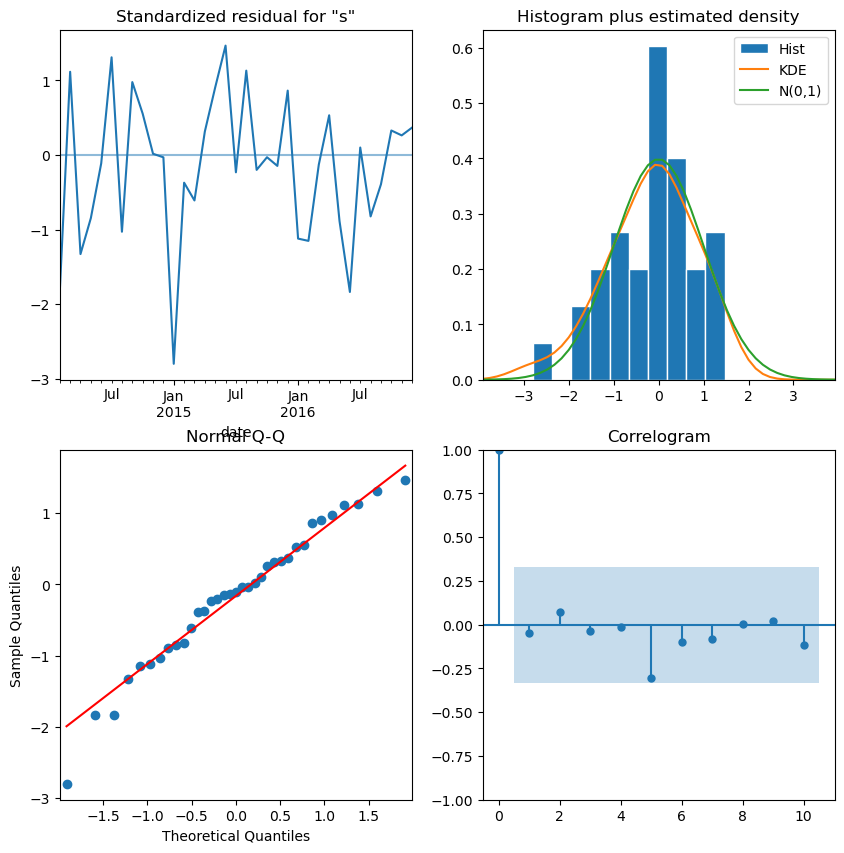

In [73]:
ax = results.plot_diagnostics(figsize=(10,10))

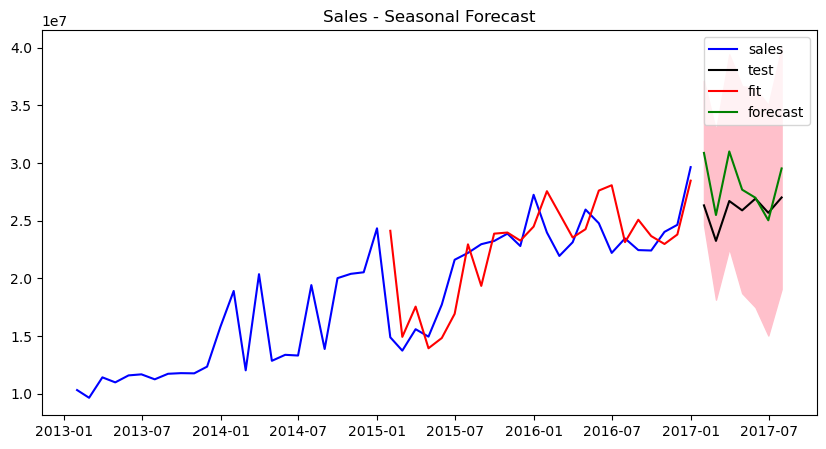

In [72]:
fig = plt.figure(figsize=(10,5))
plt.plot(y_train.index, y_train, color='blue', label='sales')
plt.plot(y_test.index, y_test, color='black', label = 'test')
plt.plot(y_fit.index, y_fit, color='red', label='fit')
plt.plot(y_pred_mean.index, y_pred_mean, color='green', label='forecast')
plt.fill_between(confidence_intervals.index, lower_limits, upper_limits, color='pink')
plt.title('Sales - Seasonal Forecast')
plt.legend()
plt.show();

In [69]:
# Calculating error
from sklearn.metrics import mean_squared_error as MSE

mse = MSE(y_test, y_fore_mean) ** (0.5)
mse

2778873.5121467304